<a href="https://colab.research.google.com/github/pingao2019/DS-Unit-2-Applied-Modeling/blob/master/Ping_Ao__Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My dataset is from U.S. Bureau of Labor Statistics, https://www.bls.gov/web/cewqtr.supp.toc.htm

Choose your target.----------wage.

Which column in your tabular dataset will you predict?----Average Weekly Wage

Is your problem regression or classification?-------------regression



###These data are the product of a federal-state cooperative program, the Quarterly Census of Employment and 
Wages (QCEW) program, also known as the ES-202 program. The data are derived from summaries of 
employment and total pay of workers covered by state and federal unemployment insurance (UI) legislation and 
provided by State Workforce Agencies (SWAs). The summaries are a result of the administration of state 
unemployment insurance programs that require most employers to pay quarterly taxes based on the employment 
and wages of workers covered by UI. QCEW data in this release are based on the  2017 North American Industry 
Classification System (NAICS). Data for 2019 are preliminary and subject to revision.


####The North American Industry Classification System (NAICS) is the standard used by Federal statistical agencies in classifying business establishments for the purpose of collecting, analyzing, and publishing statistical data related to the U.S. business economy.                                             

Government agencies use NAICS codes to collect data about businesses across the country. The classifications business owners use when filing taxes help government officials develop statistics and reports on various industries.

In [0]:
!pip install category_encoders==2.*

!pip install eli5

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 112kB 2.8MB/s 


# Part I. Data cleaning and feature engineering 

In [0]:
import pandas as pd
df=pd.read_excel('2019_2ndQ_wage_industry.xlsx')
print(df.shape)
df.sample(10)

(62742, 21)


,Area\nCode,St,Cnty,Own,NAICS,Year,Qtr,Area Type,St Name,Area,Ownership,Industry,Status Code,Establishment Count,April Employment,May Employment,June Employment,Total Quarterly Wages,Average Weekly Wage,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.
49745,49033,49,33.0,3,10,2019,2,County,Utah,"Rich County, Utah",Local Government,"10 Total, all industries",NaN,18,182,201,159,1522047,648,1.43,2.44
768,01087,01,87.0,2,10,2019,2,County,Alabama,"Macon County, Alabama",State Government,"10 Total, all industries",NaN,15,890,890,890,11979645,1035,6.31,6.66
26247,28135,28,135.0,5,10,2019,2,County,Mississippi,"Tallahatchie County, Mississippi",Private,"10 Total, all industries",NaN,179,1853,1886,1831,15737736,652,0.76,0.75
49642,49021,49,21.0,2,10,2019,2,County,Utah,"Iron County, Utah",State Government,"10 Total, all industries",NaN,37,1759,1924,1892,21459306,888,3.21,3.74
10844,16999,16,999.0,5,1023,2019,2,County,Idaho,"Unknown Or Undefined, Idaho",Private,1023 Financial activities,NaN,723,1161,1181,1192,24358226,1591,1.70,1.25
51629,51161,51,161.0,5,102,2019,2,County,Virginia,"Roanoke County, Virginia",Private,102 Service-providing,NaN,2179,29164,29308,29376,296184628,778,1.09,1.07
52474,51750,51,750.0,5,1027,2019,2,County,Virginia,"Radford City, Virginia",Private,1027 Other services,NaN,35,95,93,96,646154,525,0.55,0.46
6405,12061,12,61.0,3,10,2019,2,County,Florida,"Indian River County, Florida",Local Government,"10 Total, all industries",NaN,17,4634,4644,3226,61146703,1129,0.65,1.14
49949,49057,49,57.0,0,10,2019,2,County,Utah,"Weber County, Utah",Total Covered,"10 Total, all industries",NaN,6367,109500,109508,109420,1157263361,813,1.00,1.00
59769,C3134,NaN,NaN,5,1025,2019,2,MSA,NaN,"Lynchburg, VA MSA",Private,1025 Education and health services,NaN,1991,18957,19979,18371,220671431,889,1.19,1.48


### I will use pandas profiling to do some  Exploratory Data Analysis (EDA).    EDA gives us more insight into the data such as missing values, duplicates, count, mean, median, quantiles, distribution of data, correlation of variables with each other, type, right or left skrewed, and so on.

In [0]:
# Get Pandas Profiling Report
!pip install pandas-profiling
import pandas_profiling as pp
pp.ProfileReport(df)

There are 13 weeks in this quarter. According to BLS describe about this data set,"average weekly wage values are calculated by dividing quarterly total wages by the average of the three monthly."Average weekly wages are affected by the ratio of full-time to part-time workers as well as the number of 
individuals in high-paying and low-paying occupations and the incidence of pay periods within a quarter. For instance, the average weekly wage of the workforce could increase significantly when there is a large decline in 
the number of employees that had been receiving below-average wages. Wages may include payments to workers not present in the employment counts because they did not work during the pay period including the 12th of the 
month. When comparing average weekly wage levels between industries, states, or quarters, these factors should 
be taken into consideration.


## From profiling, columns have 6 Numeric and 8 Categorical variables. The target is Numeric, "Weekly Average wages".

### From  profiling's 'warn'
Year, Qtr, May Employment, June Employment, Total Quarterly Wages, Total Wage Location Quotient are duplicated and leaked, so rejected. So we need drop them.
Year and Qtr are constant, so Rejected. May Employment is highly correlated with April Employment (ρ = 1) Rejected. June Employment is highly correlated with May Employment (ρ = 0.99999) Rejected.
    Total Quarterly Wages is highly correlated with June Employment (ρ = 0.99658) Rejected.
Total Wage Location Quotient Relative to U.S. is highly correlated with Employment Location Quotient Relative to U.S. (ρ = 0.97715) Rejected

 Highly skewed variables:

Employment Location Quotient Relative to U.S is highly skewed (γ1 = 147.91) Skewed.  Establishment Count is highly skewed (γ1 = 123.04) Skewed.


Missing and zero variables:

    Area Code has a high cardinality: 3624 distinct values Warning
    St has 6709 / 10.7% missing values Missing
    St has a high cardinality: 53 distinct values Warning
    Cnty has 6709 / 10.7% missing values Missing
    Cnty has 921 / 1.5% zeros Zeros
    Own has 3624 / 5.8% zeros Zeros
    
    St Name has 6727 / 10.7% missing values Missing
    St Name has a high cardinality: 52 distinct values Warning
    Area has a high cardinality: 3623 distinct values Warning
    Status Code has 59123 / 94.2% missing values Missing
    
    Average Weekly Wage has 3732 / 5.9% zeros Zeros
    
    Employment Location Quotient Relative to U.S. has 3771 / 6.0% zeros Zeros
    
 
    April Employment is highly correlated with Establishment Count (ρ = 0.99143) Rejected

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline


In [0]:
df.isnull().sum()

Area\nCode                                           0
St                                                6709
Cnty                                              6709
Own                                                  0
NAICS                                                0
Year                                                 0
Qtr                                                  0
Area Type                                            0
St Name                                           6727
Area                                                 0
Ownership                                            0
Industry                                             0
Status Code                                      59123
Establishment Count                                  0
April Employment                                     0
May Employment                                       0
June Employment                                      0
Total Quarterly Wages                                0
Average We

In [0]:
#df['Average Weekly Wage'] = df['Average Weekly Wage'].replace(0, np.nan)

In [0]:
#df['Average Weekly Wage'] = df['Average Weekly Wage'].dropna(how='all')

In [0]:
#df=df.loc[(df!=0).any(axis=1)]
df.shape

(62742, 21)

In [0]:
#According to the profiling, we avoid leakage of information from target to features
# Drop some high cardinality categoricals and single categoricals.
df= df.drop(columns=['Year', 'Qtr', 'May Employment', 'June Employment', 'Total Quarterly Wages', 'Total Wage Location Quotient Relative to U.S.' ])

In [0]:
#Status Code has 59123 / 94.2% missing values Missing
# Drop Area which has  high cardinality categoricals
df= df.drop(columns=['St', 'Status Code','Area','Area\nCode'])

In [0]:
#df= df.drop(columns='Establishment Count')
df.shape

(62742, 11)

In [0]:
df.isnull().sum()

Cnty                                             6709
Own                                                 0
NAICS                                               0
Area Type                                           0
St Name                                          6727
Ownership                                           0
Industry                                            0
Establishment Count                                 0
April Employment                                    0
Average Weekly Wage                                 0
Employment Location Quotient Relative to U.S.       0
dtype: int64

In [0]:
df['Cnty']= df['Cnty'].replace(0, np.nan)
#df['Average Weekly Wage'] = df['Average Weekly Wage'].replace(0, np.nan)
#df['Employment Location Quotient Relative to U.S.']= df['Cnty'].replace(0, np.nan)
#df['Establishment Count']= df['Establishment Count'].replace(0, np.nan)
df['St Name']= df['St Name'].replace(0, np.nan)

In [0]:
df=df.dropna(subset=['St Name'])

In [0]:
df=df.dropna(subset=['Cnty'])

In [0]:
df.isnull().sum()

Cnty                                             0
Own                                              0
NAICS                                            0
Area Type                                        0
St Name                                          0
Ownership                                        0
Industry                                         0
Establishment Count                              0
April Employment                                 0
Average Weekly Wage                              0
Employment Location Quotient Relative to U.S.    0
dtype: int64

In [0]:
df.shape

(55112, 11)

In [0]:
df.describe()

,Cnty,Own,NAICS,Establishment Count,April Employment,Average Weekly Wage,Employment Location Quotient Relative to U.S.
count,55112.000000,62742.000000,62742.000000,6.274200e+04,6.274200e+04,59010.000000,55112.000000
mean,117.882893,4.195977,624.283399,2.453553e+03,3.350102e+04,848.902627,117.882893
std,154.070068,1.568151,483.586548,7.083353e+04,9.306942e+05,336.739036,154.070068
min,1.000000,0.000000,10.000000,1.000000e+00,0.000000e+00,9.000000,1.000000
25%,35.000000,5.000000,10.000000,1.900000e+01,1.390000e+02,655.000000,35.000000
50%,81.000000,5.000000,1012.000000,7.200000e+01,8.940000e+02,804.000000,81.000000
75%,137.000000,5.000000,1024.000000,3.730000e+02,5.259000e+03,997.000000,137.000000
max,999.000000,5.000000,1029.000000,1.025204e+07,1.475225e+08,6538.000000,999.000000


In [0]:
df.select_dtypes(exclude="number").columns.tolist()

['Area Type', 'St Name', 'Ownership', 'Industry']

In [0]:
df.select_dtypes(include="number").columns.tolist()

['Cnty',
 'Own',
 'NAICS',
 'Establishment Count',
 'April Employment',
 'Average Weekly Wage',
 'Employment Location Quotient Relative to U.S.']

In [0]:
df['Cnty'].describe()

count    56015.000000
mean       115.982540
std        153.542582
min          0.000000
25%         33.000000
50%         79.000000
75%        137.000000
max        999.000000
Name: Cnty, dtype: float64

In [0]:
df['St Name'].unique()

array([nan, 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [0]:
df['Own'].value_counts()

5    48347
0     3624
1     3621
3     3608
2     3542
Name: Own, dtype: int64

In [0]:
df['Area Type'].unique()

array(['Nation', 'State', 'County', 'MSA'], dtype=object)

In [0]:
df['Ownership'].unique()

array(['Total Covered', 'Federal Government', 'State Government',
       'Local Government', 'Private'], dtype=object)

In [0]:
df['Industry'].unique()

array(['10 Total, all industries', '101 Goods-producing',
       '1011 Natural resources and mining', '1012 Construction',
       '1013 Manufacturing', '102 Service-providing',
       '1021 Trade, transportation, and utilities', '1022 Information',
       '1023 Financial activities',
       '1024 Professional and business services',
       '1025 Education and health services',
       '1026 Leisure and hospitality', '1027 Other services',
       '1029 Unclassified'], dtype=object)

In [0]:
df['NAICS'].describe()

count    62742.000000
mean       624.283399
std        483.586548
min         10.000000
25%         10.000000
50%       1012.000000
75%       1024.000000
max       1029.000000
Name: NAICS, dtype: float64

###  The explanation about establishment:  the published employment and wage levels only reflect an entire establishment, which may consist of multiple occupations and jobs.

In [0]:
df['Establishment Count'].describe()

count    6.274200e+04
mean     2.453553e+03
std      7.083353e+04
min      1.000000e+00
25%      1.900000e+01
50%      7.200000e+01
75%      3.730000e+02
max      1.025204e+07
Name: Establishment Count, dtype: float64

In [0]:
df['Employment Location Quotient Relative to U.S.'].describe()

count    55112.000000
mean       117.882893
std        154.070068
min          1.000000
25%         35.000000
50%         81.000000
75%        137.000000
max        999.000000
Name: Employment Location Quotient Relative to U.S., dtype: float64

# Part II. Default baseline prediction,  exploring the relationships between target and some features by simple  visualization, and train, val, test split.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [0]:
px.scatter(df, x='NAICS', y='Average Weekly Wage', trendline='ols')


In [0]:
# My target to predict is Average Weekly Wage. From the  baseline, I guessed the majority wage for every prediction. And get baseline accuracy 
baseline= df['Average Weekly Wage'].mean()
errors = baseline- df['Average Weekly Wage']
mean_absolute_error = errors.abs().mean()
print(f'If we just guessed every wage for ${baseline:,.3f},')
print(f'we would be off by ${mean_absolute_error:,.3f} on average.')

If we just guessed every wage for $848.986,
we would be off by $237.936 on average.


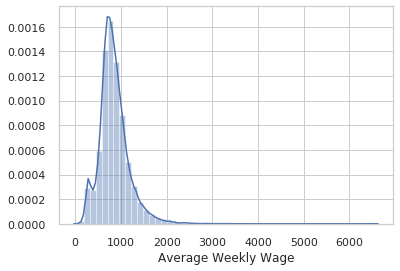

In [0]:
import seaborn as sns
y= df['Average Weekly Wage']
sns.distplot(y);

### Lower bound and Upper Bound are numberic data. From following I will check whether they are outliers.   I do need  exclude them.

In [0]:
df['Average Weekly Wage'].describe()

count    56015.000000
mean       784.797394
std        378.822121
min          0.000000
25%        611.000000
50%        770.000000
75%        964.000000
max       6538.000000
Name: Average Weekly Wage, dtype: float64

There are lower and upper bound outliers in my target. 

In [0]:
df = df[(df['Average Weekly Wage'] >= np.percentile(df['Average Weekly Wage'], 0.5)) & 
       (df['Average Weekly Wage'] <= np.percentile(df['Average Weekly Wage'], 99.5))]
       

In [0]:
df=df[(df['Average Weekly Wage']>10)]

In [0]:
df.shape

(51201, 11)

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                               random_state=42)

train.shape, test.shape 

((40960, 11), (10241, 11))

In [0]:
train, val = train_test_split(train,  test_size=0.2,random_state=42)
train.shape,  val.shape

((32768, 11), (8192, 11))

In [0]:
target = 'Average Weekly Wage'
features= df.columns. drop([target])

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test =test[target]

In [0]:
df.corr()

,Cnty,Own,NAICS,Establishment Count,April Employment,Average Weekly Wage,Employment Location Quotient Relative to U.S.
Cnty,1.000000,-0.000785,0.003440,0.025344,-0.008449,0.138340,0.048685
Own,-0.000785,1.000000,0.641066,-0.041323,-0.064634,-0.172187,0.006107
NAICS,0.003440,0.641066,1.000000,-0.093087,-0.115270,-0.152596,0.004964
Establishment Count,0.025344,-0.041323,-0.093087,1.000000,0.916535,0.103297,0.001646
April Employment,-0.008449,-0.064634,-0.115270,0.916535,1.000000,0.119844,-0.002348
Average Weekly Wage,0.138340,-0.172187,-0.152596,0.103297,0.119844,1.000000,0.061634
Employment Location Quotient Relative to U.S.,0.048685,0.006107,0.004964,0.001646,-0.002348,0.061634,1.000000


In [0]:
import matplotlib.pyplot as plt

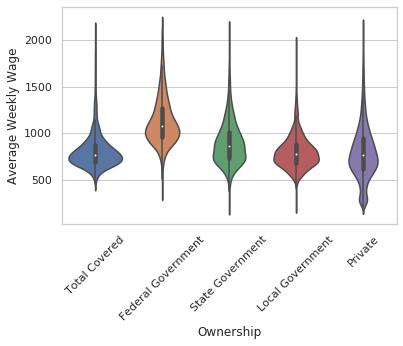

In [0]:
#ViolinPlot(X_train, 'Area')
import seaborn as sns

sns.set(style="whitegrid")
ax = sns.violinplot(x="Ownership", y='Average Weekly Wage',showmeans=True, showextrema=True, showmedians=True, data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

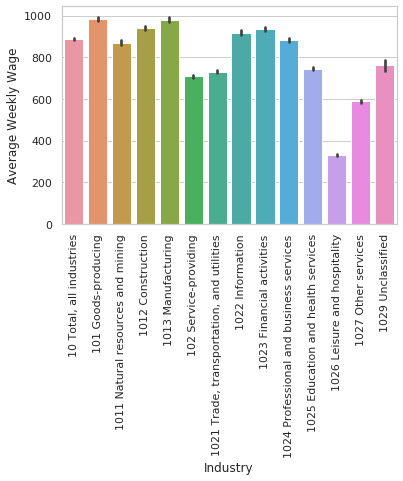

In [0]:
# Comparison barchart, hue="Area Type"
sns.barplot(x="Industry", y='Average Weekly Wage',  data=df)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=15);
plt.xticks(rotation=90)

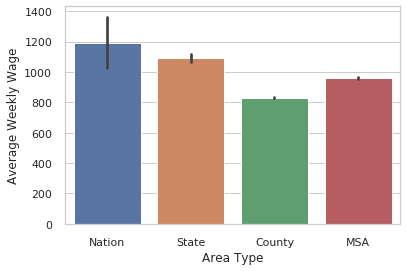

In [0]:
sns.barplot(x='Area Type', y='Average Weekly Wage',data=df);
#ax.set_xticklabels(ax.get_xticklabels(),rotation=15);

In [0]:
target = 'Average Weekly Wage'
features= df.columns. drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test =test[target]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

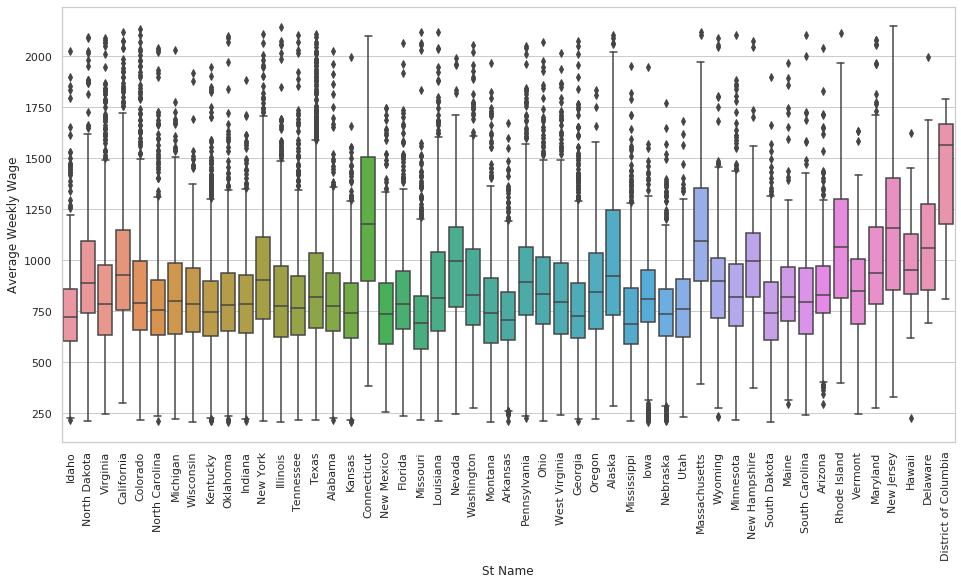

In [0]:
# Plot boxplots for St
width = 16
height = 8
var = 'St Name'
data = pd.concat([y_train, X_train[var]], axis=1)
f, ax = plt.subplots(figsize=(width, height))
fig = sns.boxplot(x=var, y='Average Weekly Wage', data=data)
plt.xticks(rotation=90)

# Part III. To evaluate the prediction Mae or R^2 from different prediction methods. 



The MSE, MAE, RMSE, and R-Squared metrics are mainly used to evaluate the prediction error rates and model performance in regression analysis. MAE (Mean absolute error) represents the difference between the original and predicted values extracted by averaged the absolute difference over the data set.



In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

##Method 1 LinearRegression

In [0]:
#Model 1 LinearRegression

pipeline = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

pipeline.fit(X_train, y_train)
print('Linear Regression R^2', pipeline.score(X_val, y_val))

Linear Regression R^2 0.45950739555803616


In [0]:
coefficients = pipeline.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

Cnty                                             3.004755e-01
Own                                              1.427972e+01
NAICS                                            4.980965e-02
Area Type                                       -2.605693e-13
St Name                                          9.824301e-01
Ownership                                        1.052776e+00
Industry                                         1.006530e+00
Establishment Count                             -5.403542e-03
April Employment                                 9.625283e-04
Employment Location Quotient Relative to U.S.    2.463771e+00
dtype: float64

## Method 2:  DecisionTreeRegressor with log  transformation .

In [0]:
#Method 2
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(), 
    DecisionTreeRegressor()
)


In [0]:
import numpy as np
y_train_log = np.log1p(y_train)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print(mean_absolute_error(y_val, y_pred))

161.862548828125


In [0]:
# Model 2 Ridge with Cross_validation
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=20), 
    Ridge(alpha=1.0)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib

MAE for 3 folds: [161.85303147 160.80745876 166.47370128]


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


###Method 3: Ridge with Randomized Search CV. To find  vary multiple hyperparameters and find their optimal values. 

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    SelectKBest(f_regression), 
    Ridge()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 105

In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'mean', 'selectkbest__k': 10, 'ridge__alpha': 0.1}
Cross-validation MAE 174.59685995472503


##Method 4: fit RandomForestRegressor model

In [0]:
#Method 4: fit RandomForestRegressor model
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(max_depth=2)
)
pipeline.fit(X_train,y_train)
print('R^2:', pipeline.score(X_val,y_val))

Validation Accuracy: 0.2772580783374128


##Method 5: fit RandomForestRegressor model with cross_validation. 

In [0]:
pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [123.70900027 123.74373798 125.74829061]


In [0]:
pipeline.fit(X_train, y_train)
print('R^2', pipeline.score(X_val, y_val))

  R^2 0.6528145836583588


## Method 6: fit XGBRegressor model

In [0]:
# Method 5: XGBRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.6103002441245255


In [0]:

# increase the dots per inch (double it), so the text isn't so fuzzy
#import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 72

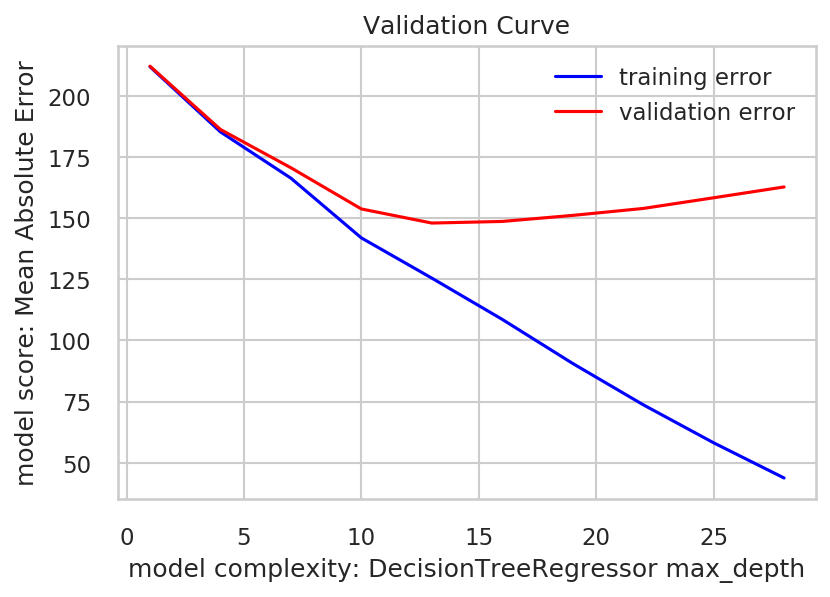

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(), 
    DecisionTreeRegressor()
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='decisiontreeregressor__max_depth', 
    param_range=depth, scoring='neg_mean_absolute_error', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: DecisionTreeRegressor max_depth')
plt.ylabel('model score: Mean Absolute Error')
plt.legend();

In [0]:
#y_pred = pipeline.predict(X_val)
#print('R^2', pipeline.score(X_val, y_val))

In [0]:
import graphviz

In [0]:
# This score is too good to be true.
# Visualize the RandomeForestClassification to see what the model "learned"
target = 'Average Weekly Wage'
features= df.columns. drop([target])
X_train =X_train[features]

X_val = X_val[features]


In [0]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
# Ignore warnings

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
     
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100

In [0]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Area Type                                        0.000000
St Name                                          0.043103
Cnty                                             0.090383
Ownership                                        0.095819
Employment Location Quotient Relative to U.S.    0.106188
Own                                              0.158209
Industry                                         0.302590
NAICS                                            0.345290
Establishment Count                              0.442971
April Employment                                 0.804577
dtype: float64

In [0]:
#  Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.8046 ± 0.0269,April Employment
0.4430 ± 0.0086,Establishment Count
0.3453 ± 0.0186,NAICS
0.3026 ± 0.0107,Industry
0.1582 ± 0.0117,Own
0.1062 ± 0.0087,Employment Location Quotient Relative to U.S.
0.0958 ± 0.0050,Ownership
0.0904 ± 0.0079,Cnty
0.0431 ± 0.0064,St Name
0 ± 0.0000,Area Type


In [0]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error

Make at least 1 partial dependence plot to explain your model.
Make at least 1 Shapley force plot to explain an individual prediction.
Share at least 1 visualization (of any type) on Slack!

In [0]:
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:

!pip install pdpbox
!pip install shap

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [0]:
df.columns.to_list()

['Area\nCode',
 'Cnty',
 'Own',
 'NAICS',
 'Area Type',
 'St Name',
 'Ownership',
 'Industry',
 'Establishment Count',
 'Average Weekly Wage',
 'Employment Location Quotient Relative to U.S.']

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature= 'Employment Location Quotient Relative to U.S.'
isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


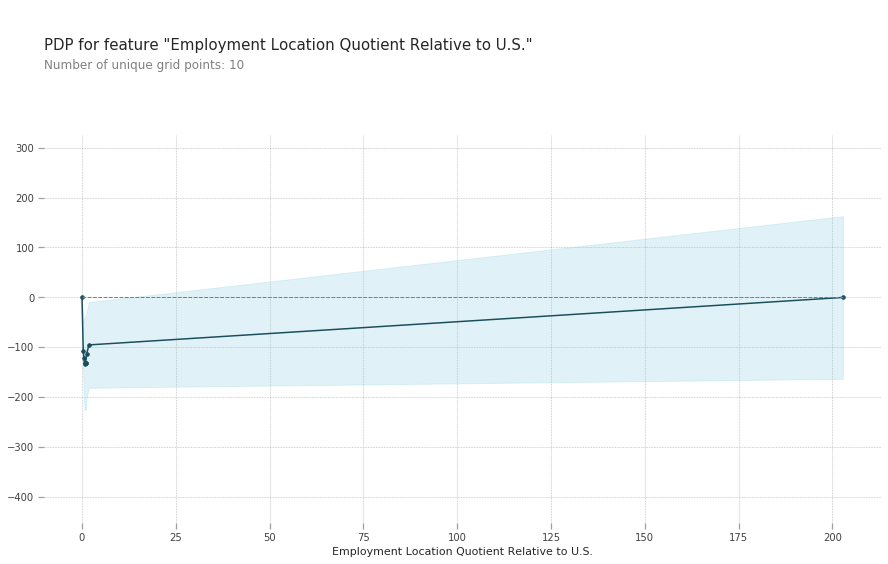

In [0]:
pdp_plot(isolated, feature_name=feature);

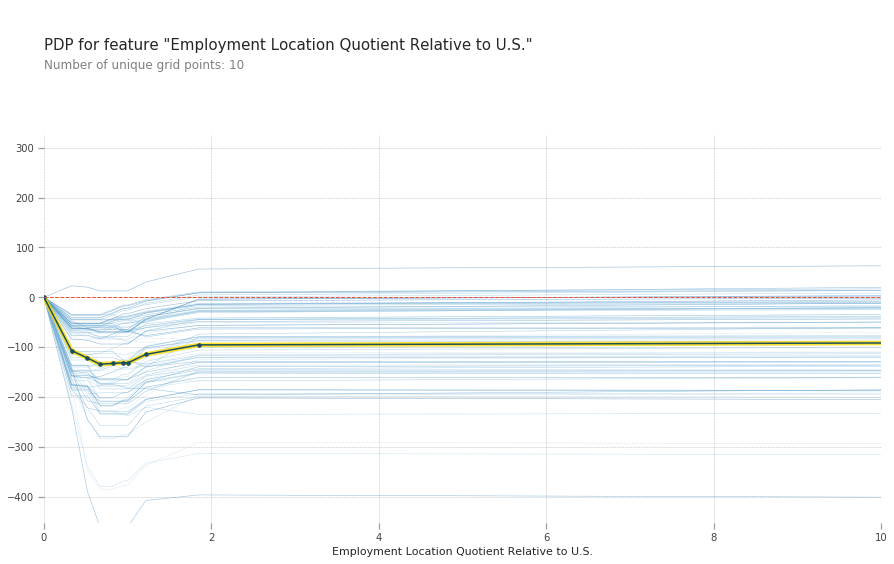

In [0]:
# Plot PDP with ICE curves
# PDP: Partial Dependence Plot
# ICE: Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)

plt.xlim(0, 10);

Partial Dependence Plots with 2 features

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
#train.select_dtypes(exclude="number").columns.tolist()

['Area Type', 'St Name', 'Ownership', 'Industry']

In [0]:
train.select_dtypes(include="number").columns.tolist()

['Cnty',
 'Own',
 'NAICS',
 'Establishment Count',
 'April Employment',
 'Average Weekly Wage',
 'Employment Location Quotient Relative to U.S.']

In [0]:

features = ['Cnty', 'Own']

interaction = pdp_interact(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


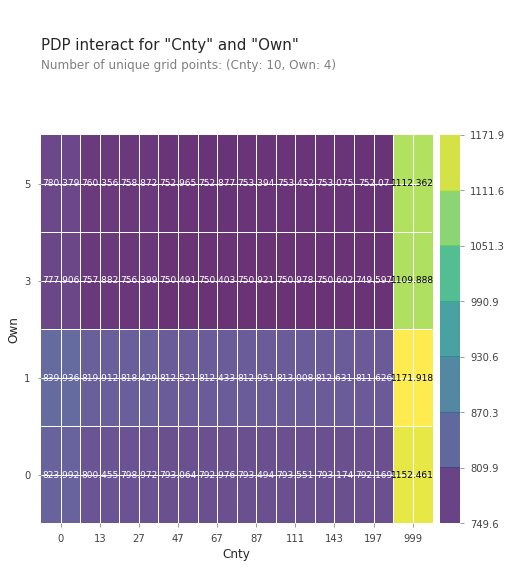

In [0]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [0]:
#  3D with Plotly. First, make the 2D plot above. Then ...

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending

In [0]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

##Explain individual predictions with shapley value plots

In [0]:
train.columns.to_list()

['Cnty',
 'Own',
 'NAICS',
 'Area Type',
 'St Name',
 'Ownership',
 'Industry',
 'Establishment Count',
 'April Employment',
 'Average Weekly Wage',
 'Employment Location Quotient Relative to U.S.']

In [0]:
# Assign to X, y
features = ['Own', 'NAICS', 'Establishment Count', 'April Employment']
target = 'Average Weekly Wage'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   13.6s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   20.6s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 15, 'max_features': 0.020584494295802447, 'n_estimators': 307}
Cross-validation MAE 142.05143561237324


In [0]:
# Get an individual observation to explain.
# For example, the 0th row from the test set.

row = X_test.iloc[[0]] # Dataframe with a single row (double brackets keeps it a dataframe)
row

,Own,NAICS,Establishment Count,April Employment
22635,3,10,58,1494


In [0]:
y_test.iloc[[0]]

22635    804
Name: Average Weekly Wage, dtype: int64

In [0]:
# What does the model predict for this apartment?
model.predict(row)

array([809.70101725])

In [0]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot

import shap

In [0]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

In [0]:
# Base value is approximately equal to the mean baseline
explainer.expected_value, y_train.mean()

(array([824.34170512]), 824.3177185058594)

In [0]:
# Let's look at the Shapley values for each feature ...
# How much eeach added or subtracted to the prediction

feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps

(Own, 3)                    -86.705778
(NAICS, 10)                   6.354777
(Establishment Count, 58)    32.367207
(April Employment, 1494)     33.343107
dtype: float64

In [0]:
# Add them up ...
shaps.sum()

-14.640687875661953

In [0]:
# To get the predicted value
explainer.expected_value + shaps.sum() 

array([809.70101725])